In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [32]:
planning_area_encoder = OneHotEncoder(sparse=False)
model_encoder = TargetEncoder()
date_encoder = TargetEncoder()
street_encoder = TargetEncoder()

def clean(X):
    X['rent_approval_date'] = X['rent_approval_date'].str[2:].str.replace('-', '', regex=False)
    X['rent_approval_date'] = X['rent_approval_date'].astype(int)
    X['street_name'] = X['street_name'].apply(str.lower)
    X['flat_type'] = X['flat_type'].str.replace(r'(2|3|4|5)-room|(\d) room', r'\1\2', regex=True)
    X['flat_type'] = X['flat_type'].str.replace('executive', '6')
    X['flat_type'] = X['flat_type'].astype(int)
    X = X.drop(columns=['furnished', 'elevation', 'town', 'block', 'region', 'subzone', 'street_name'])
    
    return X
    
def one_hot_encode(X):
    
    data_encoded = pd.get_dummies(X, columns=['planning_area'])
    
    return data_encoded   


def target_encode(X, isTest=False):
    if not isTest:
        model_encoder.fit(X['flat_model'], X['monthly_rent'])
        # X['street_name'] = street_encoder.fit_transform(X['street_name'],  X['monthly_rent'])
        # X['date_encoded'] = date_encoder.fit_transform(X['rent_approval_date'].astype(str),  X['monthly_rent'])
        # X['type_by_date_encoded'] = type_by_date.fit_transform(X['rent_approval_date'].astype(str)+X['flat_type'].astype(str), X['monthly_rent'])
        
    X['flat_model'] = model_encoder.transform(X['flat_model'])
    # X['street_name'] = street_encoder.transform(X['street_name'])
    # X['date_encoded'] = date_encoder.transform(X['rent_approval_date'].astype(str))
    # X['type_by_date_encoded'] = type_by_date.transform(X['rent_approval_date'].astype(str)+X['flat_type'].astype(str))
    return X

def preprocess_data(X, isTest=False):
    X = clean(X)
    X = one_hot_encode(X)
    X = target_encode(X, isTest)
    X = utils.calculate_distance_to_facilities(X)
    return X


In [33]:
def prep_data_for_xgboost():
    training_data_raw = pd.read_csv('Datasets/train.csv')
    
    X_train, X_val = train_test_split(training_data_raw, test_size=0.2, random_state=42)
    
    X_train = preprocess_data(X_train)
    X_train, y_train = X_train.drop('monthly_rent', axis=1), X_train[['monthly_rent']]
    X_val = preprocess_data(X_val, True)
    X_val, y_val = X_val.drop('monthly_rent', axis=1), X_val[['monthly_rent']]
    
    print("Shape of training data: ", X_train.shape)
    print("Shape of training label: ", y_train.shape)
    print("Shape of validation data: ", X_val.shape)
    print("Shape of validation label: ", y_val.shape)

    return X_train, y_train, X_val, y_val

In [34]:
def prep_data_for_xgboost():
    training_data_raw = pd.read_csv('Datasets/train.csv')
        
    X_train = preprocess_data(training_data_raw)
    X_train, y_train = X_train.drop('monthly_rent', axis=1), X_train[['monthly_rent']]
   
    print("Shape of training data: ", X_train.shape)
    print("Shape of training label: ", y_train.shape)

    return X_train, y_train

In [35]:
X_train, y_train, X_val, y_val = prep_data_for_xgboost()
X_train, y_train = prep_data_for_xgboost()
X_train.head()

Shape of training data:  (60000, 38)
Shape of training label:  (60000, 1)


,rent_approval_date,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,planning_area_ang mo kio,planning_area_bedok,planning_area_bishan,...,planning_area_rochor,planning_area_sembawang,planning_area_sengkang,planning_area_serangoon,planning_area_tampines,planning_area_toa payoh,planning_area_woodlands,planning_area_yishun,distance_to_nearest_existing_mrt,distance_to_nearest_shopping_mall
0,2109,3,2369.965462,67.0,1983,1.344518,103.738630,False,False,False,...,False,False,False,False,False,False,False,False,0.699127,1.202674
1,2205,4,2369.965462,92.0,1978,1.330186,103.938717,False,True,False,...,False,False,False,False,False,False,False,False,0.898991,1.114338
2,2210,3,2636.211052,67.0,1971,1.332242,103.845643,False,False,False,...,False,False,False,False,False,True,False,False,0.218603,0.468297
3,2108,6,2878.725962,149.0,1993,1.370239,103.962894,False,False,False,...,False,False,False,False,False,False,False,False,1.546040,0.402359
4,2211,3,2636.211052,68.0,1972,1.320502,103.863341,False,False,False,...,False,False,False,False,False,False,False,False,0.187856,1.073354


In [36]:
testing_data_raw = pd.read_csv('Datasets/test.csv')

In [37]:
X_test = preprocess_data(testing_data_raw, isTest=True)

In [38]:
xgb_model = xgb.XGBRegressor(
            n_estimators=2300, max_depth=5, eta=0.01, gamma = 0.2, subsample=0.8, colsample_bytree=0.8,
            objective="reg:squarederror"
        )
xgb_model.fit(X_train, y_train)
y_val_pred = xgb_model.predict(X_val)
print('Validation loss:', np.sqrt(mean_squared_error(y_val, y_val_pred)))
y_train_pred = xgb_model.predict(X_train)
print('Training loss:', np.sqrt(mean_squared_error(y_train, y_train_pred)))

Training loss: 458.3271295560177


In [39]:
final_pred = xgb_model.predict(X_test)  
print("Length of final predictions is: ", len(final_pred))
ids = np.arange(30000)
df = pd.DataFrame({'Id': ids, 'Predicted': final_pred})
df.to_csv("xgboost_aux_school_planning_area_all_team18.csv", index=False)

Length of final predictions is:  30000


In [40]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

In [41]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Lasso Regression with cross-validation
lasso = LassoCV(cv=kfold, random_state=42)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Lasso Regression Root Mean Squared Error: {rmse}")

/Users/zhangguangzesheng/miniforge3/envs/CS5228/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Regression Root Mean Squared Error: 550.4108775556292


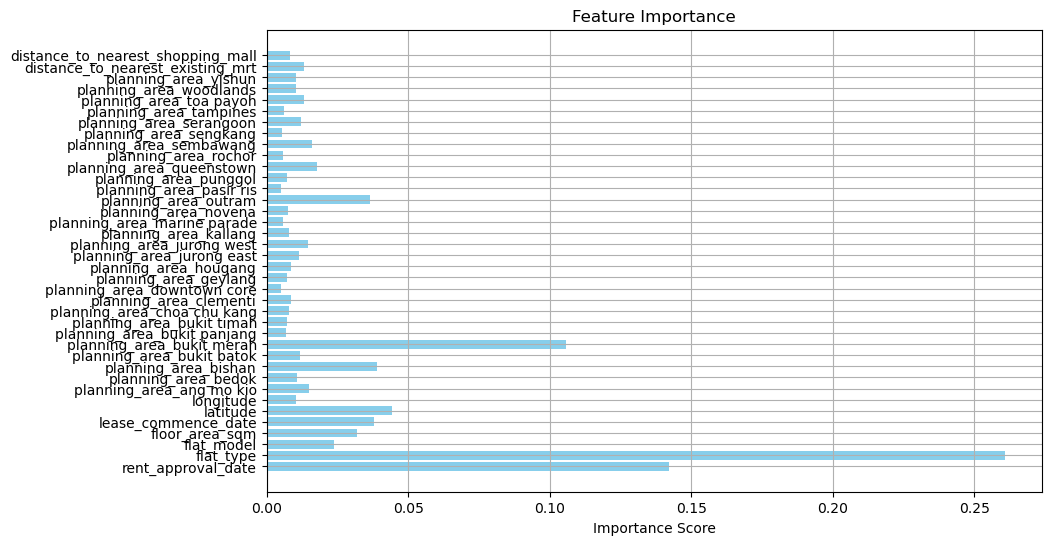

In [42]:
FI_xgb = pd.DataFrame({"Feature Importance":xgb_model.feature_importances_}, index=X_train.columns)
plt.figure(figsize=(10, 6))
plt.barh(FI_xgb.index, FI_xgb['Feature Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.grid(True)
plt.show()

In [43]:
X_train.columns

Index(['rent_approval_date', 'flat_type', 'flat_model', 'floor_area_sqm',
       'lease_commence_date', 'latitude', 'longitude',
       'planning_area_ang mo kio', 'planning_area_bedok',
       'planning_area_bishan', 'planning_area_bukit batok',
       'planning_area_bukit merah', 'planning_area_bukit panjang',
       'planning_area_bukit timah', 'planning_area_choa chu kang',
       'planning_area_clementi', 'planning_area_downtown core',
       'planning_area_geylang', 'planning_area_hougang',
       'planning_area_jurong east', 'planning_area_jurong west',
       'planning_area_kallang', 'planning_area_marine parade',
       'planning_area_novena', 'planning_area_outram',
       'planning_area_pasir ris', 'planning_area_punggol',
       'planning_area_queenstown', 'planning_area_rochor',
       'planning_area_sembawang', 'planning_area_sengkang',
       'planning_area_serangoon', 'planning_area_tampines',
       'planning_area_toa payoh', 'planning_area_woodlands',
       'planning

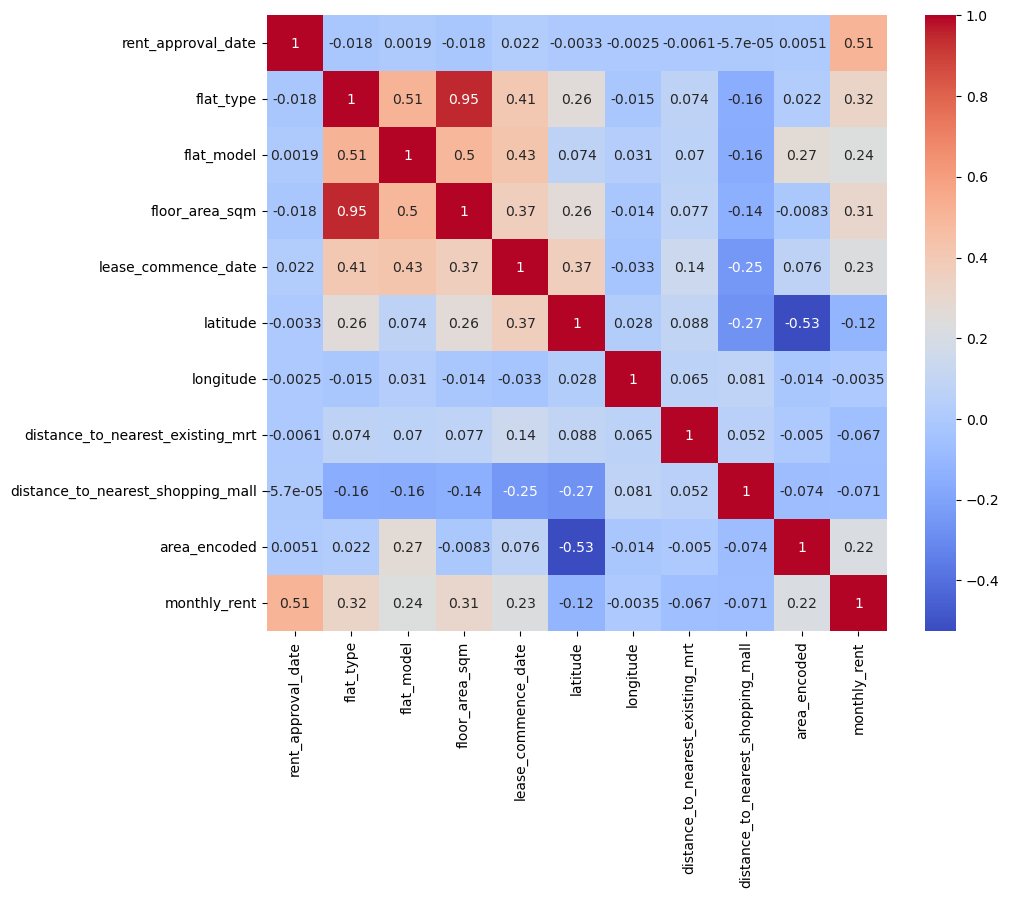

In [44]:
copy = X_train.drop(columns=['planning_area_ang mo kio', 'planning_area_bedok',
       'planning_area_bishan', 'planning_area_bukit batok',
       'planning_area_bukit merah', 'planning_area_bukit panjang',
       'planning_area_bukit timah', 'planning_area_choa chu kang',
       'planning_area_clementi', 'planning_area_downtown core',
       'planning_area_geylang', 'planning_area_hougang',
       'planning_area_jurong east', 'planning_area_jurong west',
       'planning_area_kallang', 'planning_area_marine parade',
       'planning_area_novena', 'planning_area_outram',
       'planning_area_pasir ris', 'planning_area_punggol',
       'planning_area_queenstown', 'planning_area_rochor',
       'planning_area_sembawang', 'planning_area_sengkang',
       'planning_area_serangoon', 'planning_area_tampines',
       'planning_area_toa payoh', 'planning_area_woodlands',
       'planning_area_yishun',])
training_data_raw = pd.read_csv('Datasets/train.csv')

encoder = TargetEncoder()
copy['area_encoded'] = encoder.fit_transform(training_data_raw['planning_area'], training_data_raw['monthly_rent'])

copy['monthly_rent'] = training_data_raw['monthly_rent']

corr = copy.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Show the plot
plt.show()


#### Stacking models

In [45]:
# from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
# from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import RobustScaler, StandardScaler
# from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
# from sklearn.model_selection import KFold, cross_val_score

In [46]:
# # 定义一个交叉评估函数 Validation function
# n_folds = 5
# X = pd.concat((X_train, X_val),sort=False)
# y = pd.concat((y_train, y_val),sort=False)
# def rmsle_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
#     rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)

In [47]:
# # LASSO Regression
# lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.1, random_state=42, max_iter=5000))
# score = rmsle_cv(lasso)
# print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [48]:
# # Gradient Boosting Regression
# GBoost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# score = rmsle_cv(GBoost)
# print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) 

In [49]:
# # XGBoost     
# model_xgb = xgb.XGBRegressor(n_estimators=1800, max_depth=5, eta=0.01, subsample=0.7, colsample_bytree=0.7,
#             objective="reg:squarederror")

# score = rmsle_cv(model_xgb)
# print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [50]:
# # 堆叠模型(Stacking Averaged Models) 
# class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, base_models, meta_model, n_folds=5):
#         self.base_models = base_models
#         self.meta_model = meta_model
#         self.n_folds = n_folds
        
   
#     def fit(self, X, y):
#         self.base_models_ = [list() for x in self.base_models]  #  4×5 list 存放训练好的模型
#         self.meta_model_ = clone(self.meta_model) # 复制基准模型，因为这里会有多个模型
#         kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
#         # 训练基准模型，基于基准模型训练的结果导出成特征
#         # that are needed to train the cloned meta-model
#         out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
#         for i, model in enumerate(self.base_models):
#             for train_index, holdout_index in kfold.split(X, y): #分为预测holdout_index和训练train_index
#                 instance = clone(model)
#                 self.base_models_[i].append(instance)
#                 instance.fit(X[train_index], y[train_index])
#                 y_pred = instance.predict(X[holdout_index])
#                 out_of_fold_predictions[holdout_index, i] = y_pred
                
#         # 将基准模型预测数据作为特征用来给meta_model训练
#         self.meta_model_.fit(out_of_fold_predictions, y)
#         return self
    
#     def predict(self, X):
#         meta_features = np.column_stack([
#             np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
#         return self.meta_model_.predict(meta_features)

In [51]:
# meta_model = model_xgb
# stacked_averaged_models = StackingAveragedModels(base_models = (GBoost, model_xgb),
#                                                  meta_model = meta_model,
#                                                 n_folds=10)
# score = rmsle_cv(stacked_averaged_models)
# print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [52]:
# final_pred = xgb_model.predict(X_test)  
# print("Length of final predictions is: ", len(final_pred))
# ids = np.arange(30000)
# df = pd.DataFrame({'Id': ids, 'Predicted': final_pred})
# df.to_csv("stack_team18_submission.csv", index=False)